In [75]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from polygon import RESTClient
import json
from sklearn.linear_model import LinearRegression
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
client = RESTClient(auth_key="JeeOjlOPBe5aTiQ_Jb39raRqlam45uAO")

def getTickerDailyData(client, ticker="IBM", start="2023-01-01", end="2023-02-01"):
    print("Starting data pull for {}".format(ticker))
    data = []
    date_range = pd.date_range(start, end, freq='B')
    for business_day in date_range:
        try:
            response = client.stocks_equities_daily_open_close(symbol=ticker, date=str(business_day)[0:10])
            data.append([pd.to_datetime(response.from_) ,response.open, response.close, response.high, response.low, ticker])
        except:
            continue
    return pd.DataFrame(data, columns=['date', 'open', 'close', 'high', 'low', 'ticker'])

In [22]:
ezpw_data = getTickerDailyData(client, ticker="EZPW", start="2018-01-01", end="2023-02-01")

Starting data pull for EZPW


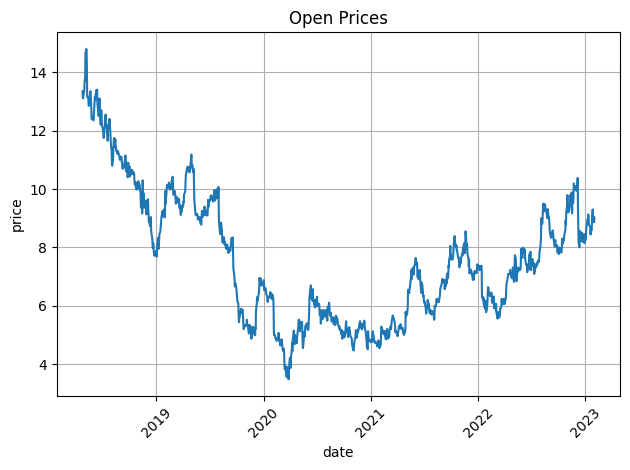

In [23]:
fig, ax = plt.subplots()
ax.plot(ezpw_data.date.values, ezpw_data.open.values)

ax.set(xlabel='date', ylabel='price', title="Open Prices")
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.grid()
fig.tight_layout()
plt.show()

 Build Model

Our first model, will be a SA-ARISMA model using only the series itself, predicting one day in advance then incorporating that data into its next daily prediction. Seasonally Adjusted, Autoregressive, Integrated, Simple moving average model. 

In [25]:
ezpw_data.head()

ezpw_data_open = ezpw_data[['date', 'open', 'ticker']]

In [26]:
ezpw_data_open.head()

,date,open,ticker
0,2018-04-24,13.35,EZPW
1,2018-04-25,13.15,EZPW
2,2018-04-26,13.10,EZPW
3,2018-04-27,13.20,EZPW
4,2018-04-30,13.35,EZPW


In [53]:
ezpw_data_open["ar1"] = ezpw_data_open['open'].shift(1)
ezpw_data_open["ar2"] = ezpw_data_open['open'].shift(2)
ezpw_data_open["ar3"] = ezpw_data_open['open'].shift(3)
ezpw_data_open["ar4"] = ezpw_data_open['open'].shift(4)
ezpw_data_open["SMA"] = ezpw_data_open['ar1'].rolling(5).mean()
ezpw_data_open["int"] = ezpw_data_open.ar1 - ezpw_data_open.ar2
ezpw_data_open['intercept'] = np.ones(len(ezpw_data_open))

In [55]:
ezpw_data_open.head()

,date,open,ticker,ar1,ar2,ar3,ar4,SMA,int,intercept
0,2018-04-24,13.35,EZPW,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,2018-04-25,13.15,EZPW,13.35,NaN,NaN,NaN,NaN,NaN,1.0
2,2018-04-26,13.10,EZPW,13.15,13.35,NaN,NaN,NaN,-0.20,1.0
3,2018-04-27,13.20,EZPW,13.10,13.15,13.35,NaN,NaN,-0.05,1.0
4,2018-04-30,13.35,EZPW,13.20,13.10,13.15,13.35,NaN,0.10,1.0


In [56]:
ezpw_data_open.shape

(1203, 10)

In [57]:
train_data = ezpw_data_open[5:500]

In [60]:
train_data.head()

,date,open,ticker,ar1,ar2,ar3,ar4,SMA,int,intercept
5,2018-05-01,13.65,EZPW,13.35,13.20,13.10,13.15,13.23,0.15,1.0
6,2018-05-02,13.75,EZPW,13.65,13.35,13.20,13.10,13.29,0.30,1.0
7,2018-05-03,13.70,EZPW,13.75,13.65,13.35,13.20,13.41,0.10,1.0
8,2018-05-04,14.65,EZPW,13.70,13.75,13.65,13.35,13.53,-0.05,1.0
9,2018-05-07,14.80,EZPW,14.65,13.70,13.75,13.65,13.82,0.95,1.0


In [79]:
reg = LinearRegression()

In [80]:
fit_model = reg.fit(train[['ar1','ar2', 'SMA', 'int']], train_data[['open']])

In [81]:
fit_model.coef_

array([[0.66633001, 0.28348342, 0.04567632, 0.38284659]])

In [82]:
fit_model.intercept_

array([0.02308977])

In [65]:
fit_model.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}

In [67]:
train_data['prediction_insample'] = fit_model.predict(train_data[['ar1','ar2', 'SMA', 'int']])

/Users/adampetranovich/projects/invenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [69]:
train_data.head()

,date,open,ticker,ar1,ar2,ar3,ar4,SMA,int,intercept,prediction_insample
5,2018-05-01,13.65,EZPW,13.35,13.20,13.10,13.15,13.23,0.15,1.0,13.322301
6,2018-05-02,13.75,EZPW,13.65,13.35,13.20,13.10,13.29,0.30,1.0,13.624890
7,2018-05-03,13.70,EZPW,13.75,13.65,13.35,13.20,13.41,0.10,1.0,13.705480
8,2018-05-04,14.65,EZPW,13.70,13.75,13.65,13.35,13.53,-0.05,1.0,13.648566
9,2018-05-07,14.80,EZPW,14.65,13.70,13.75,13.65,13.82,0.95,1.0,14.663498


In [72]:
train_data['error'] = train_data.open - train_data.prediction_insample
train_data['sq_error'] = train_data['error']**2
train_data['abs_error'] = np.abs(train_data['error'])

/Users/adampetranovich/projects/invenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/adampetranovich/projects/invenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/adampetranovich/projects/invenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [73]:
train_data

,date,open,ticker,ar1,ar2,ar3,ar4,SMA,int,intercept,prediction_insample,error,sq_error,abs_error
5,2018-05-01,13.6500,EZPW,13.3500,13.2000,13.1000,13.1500,13.2300,0.1500,1.0,13.322301,0.327699,0.107386,0.327699
6,2018-05-02,13.7500,EZPW,13.6500,13.3500,13.2000,13.1000,13.2900,0.3000,1.0,13.624890,0.125110,0.015652,0.125110
7,2018-05-03,13.7000,EZPW,13.7500,13.6500,13.3500,13.2000,13.4100,0.1000,1.0,13.705480,-0.005480,0.000030,0.005480
8,2018-05-04,14.6500,EZPW,13.7000,13.7500,13.6500,13.3500,13.5300,-0.0500,1.0,13.648566,1.001434,1.002870,1.001434
9,2018-05-07,14.8000,EZPW,14.6500,13.7000,13.7500,13.6500,13.8200,0.9500,1.0,14.663498,0.136502,0.018633,0.136502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2020-04-13,5.1505,EZPW,4.8100,4.4400,4.7200,4.4900,4.5380,0.3700,1.0,4.835736,0.314764,0.099076,0.314764
496,2020-04-14,4.8700,EZPW,5.1505,4.8100,4.4400,4.7200,4.7221,0.3405,1.0,5.164625,-0.294625,0.086804,0.294625
497,2020-04-15,4.6800,EZPW,4.8700,5.1505,4.8100,4.4400,4.7981,-0.2805,1.0,4.839969,-0.159969,0.025590,0.159969
498,2020-04-16,4.8200,EZPW,4.6800,4.8700,5.1505,4.8100,4.7901,-0.1900,1.0,4.668132,0.151868,0.023064,0.151868


In [76]:
train_data[['error', 'sq_error', 'abs_error']].mean()

error       0.000
sq_error    0.047
abs_error   0.157
dtype: float64

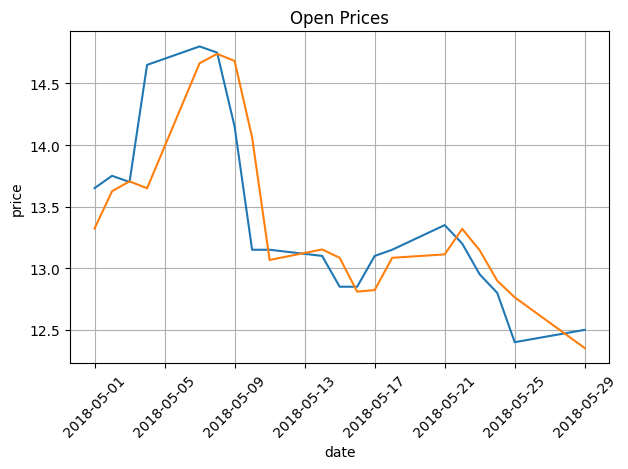

In [78]:
fig, ax = plt.subplots()
ax.plot(train_data.date.values[:20], train_data.open.values[:20])
ax.plot(train_data.date.values[:20], train_data.prediction_insample.values[:20])

ax.set(xlabel='date', ylabel='price', title="Open Prices")
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.grid()
fig.tight_layout()
plt.show()

In [83]:
test_data = ezpw_data_open[500:]

In [84]:
test_data

,date,open,ticker,ar1,ar2,ar3,ar4,SMA,int,intercept
500,2020-04-20,4.830,EZPW,5.000,4.820,4.680,4.870,4.904,0.180,1.000
501,2020-04-21,4.760,EZPW,4.830,5.000,4.820,4.680,4.840,-0.170,1.000
502,2020-04-22,4.900,EZPW,4.760,4.830,5.000,4.820,4.818,-0.070,1.000
503,2020-04-23,4.720,EZPW,4.900,4.760,4.830,5.000,4.862,0.140,1.000
504,2020-04-24,4.920,EZPW,4.720,4.900,4.760,4.830,4.842,-0.180,1.000
...,...,...,...,...,...,...,...,...,...,...
1198,2023-01-26,9.300,EZPW,9.090,9.080,8.590,8.610,8.762,0.010,1.000
1199,2023-01-27,9.070,EZPW,9.300,9.090,9.080,8.590,8.934,0.210,1.000
1200,2023-01-30,9.030,EZPW,9.070,9.300,9.090,9.080,9.026,-0.230,1.000
1201,2023-01-31,8.860,EZPW,9.030,9.070,9.300,9.090,9.114,-0.040,1.000


In [85]:
test_data['prediction_oos'] = fit_model.predict(test_data[['ar1','ar2', 'SMA', 'int']])

/Users/adampetranovich/projects/invenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [86]:
test_data.head()

,date,open,ticker,ar1,ar2,ar3,ar4,SMA,int,intercept,prediction_oos
500,2020-04-20,4.830,EZPW,5.000,4.820,4.680,4.870,4.904,0.180,1.000,5.014
501,2020-04-21,4.760,EZPW,4.830,5.000,4.820,4.680,4.840,-0.170,1.000,4.815
502,2020-04-22,4.900,EZPW,4.760,4.830,5.000,4.820,4.818,-0.070,1.000,4.757
503,2020-04-23,4.720,EZPW,4.900,4.760,4.830,5.000,4.862,0.140,1.000,4.913
504,2020-04-24,4.920,EZPW,4.720,4.900,4.760,4.830,4.842,-0.180,1.000,4.709


In [90]:
test_data['error'] = test_data.open - test_data.prediction_oos
test_data['sq_error'] = test_data['error']**2
test_data['abs_error'] = np.abs(test_data['error'])

/Users/adampetranovich/projects/invenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/adampetranovich/projects/invenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/adampetranovich/projects/invenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [91]:
test_data

,date,open,ticker,ar1,ar2,ar3,ar4,SMA,int,intercept,prediction_oos,error,sq_error,abs_error
500,2020-04-20,4.830,EZPW,5.000,4.820,4.680,4.870,4.904,0.180,1.000,5.014,-0.184,0.034,0.184
501,2020-04-21,4.760,EZPW,4.830,5.000,4.820,4.680,4.840,-0.170,1.000,4.815,-0.055,0.003,0.055
502,2020-04-22,4.900,EZPW,4.760,4.830,5.000,4.820,4.818,-0.070,1.000,4.757,0.143,0.020,0.143
503,2020-04-23,4.720,EZPW,4.900,4.760,4.830,5.000,4.862,0.140,1.000,4.913,-0.193,0.037,0.193
504,2020-04-24,4.920,EZPW,4.720,4.900,4.760,4.830,4.842,-0.180,1.000,4.709,0.211,0.044,0.211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198,2023-01-26,9.300,EZPW,9.090,9.080,8.590,8.610,8.762,0.010,1.000,9.058,0.242,0.059,0.242
1199,2023-01-27,9.070,EZPW,9.300,9.090,9.080,8.590,8.934,0.210,1.000,9.285,-0.215,0.046,0.215
1200,2023-01-30,9.030,EZPW,9.070,9.300,9.090,9.080,9.026,-0.230,1.000,9.027,0.003,0.000,0.003
1201,2023-01-31,8.860,EZPW,9.030,9.070,9.300,9.090,9.114,-0.040,1.000,9.012,-0.152,0.023,0.152


In [92]:
test_data[['error', 'sq_error', 'abs_error']].mean()

error       0.013
sq_error    0.034
abs_error   0.136
dtype: float64

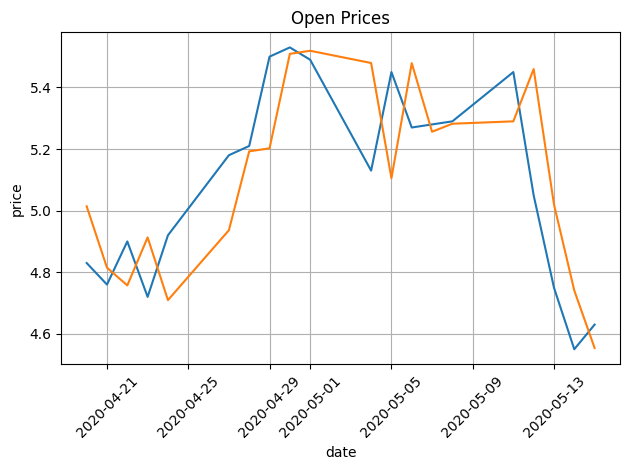

In [94]:
fig, ax = plt.subplots()
ax.plot(test_data.date.values[:20], test_data.open.values[:20])
ax.plot(test_data.date.values[:20], test_data.prediction_oos.values[:20])

ax.set(xlabel='date', ylabel='price', title="Open Prices")
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.grid()
fig.tight_layout()
plt.show()

In [95]:
fit_model2 = reg.fit(test_data[['ar1','ar2', 'SMA', 'int']], test_data[['open']])

In [96]:
test_data['prediction_inSample']= fit_model2.predict(test_data[['ar1','ar2', 'SMA', 'int']])

/Users/adampetranovich/projects/invenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [97]:
test_data

,date,open,ticker,ar1,ar2,ar3,ar4,SMA,int,intercept,prediction_oos,error,sq_error,abs_error,prediction_inSample
500,2020-04-20,4.830,EZPW,5.000,4.820,4.680,4.870,4.904,0.180,1.000,5.014,-0.184,0.034,0.184,5.016
501,2020-04-21,4.760,EZPW,4.830,5.000,4.820,4.680,4.840,-0.170,1.000,4.815,-0.055,0.003,0.055,4.851
502,2020-04-22,4.900,EZPW,4.760,4.830,5.000,4.820,4.818,-0.070,1.000,4.757,0.143,0.020,0.143,4.781
503,2020-04-23,4.720,EZPW,4.900,4.760,4.830,5.000,4.862,0.140,1.000,4.913,-0.193,0.037,0.193,4.917
504,2020-04-24,4.920,EZPW,4.720,4.900,4.760,4.830,4.842,-0.180,1.000,4.709,0.211,0.044,0.211,4.742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198,2023-01-26,9.300,EZPW,9.090,9.080,8.590,8.610,8.762,0.010,1.000,9.058,0.242,0.059,0.242,9.077
1199,2023-01-27,9.070,EZPW,9.300,9.090,9.080,8.590,8.934,0.210,1.000,9.285,-0.215,0.046,0.215,9.283
1200,2023-01-30,9.030,EZPW,9.070,9.300,9.090,9.080,9.026,-0.230,1.000,9.027,0.003,0.000,0.003,9.060
1201,2023-01-31,8.860,EZPW,9.030,9.070,9.300,9.090,9.114,-0.040,1.000,9.012,-0.152,0.023,0.152,9.019


In [98]:
test_data['in_sample_error'] = test_data.open - test_data.prediction_inSample
test_data['in_sample_sq_error'] = test_data['in_sample_error']**2
test_data['in_sample_abs_error'] = np.abs(test_data['in_sample_error'])

/Users/adampetranovich/projects/invenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/adampetranovich/projects/invenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/adampetranovich/projects/invenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [99]:
test_data[['in_sample_error', 'in_sample_sq_error', 'in_sample_abs_error']].mean()

in_sample_error       -0.000
in_sample_sq_error     0.033
in_sample_abs_error    0.136
dtype: float64